In [109]:
# IMPORT HANDLER

import os
import os.path

import cedalion
import cedalion.nirs
import cedalion.xrutils
import cedalion.xrutils as xrutils
from cedalion.datasets import get_fingertapping_snirf_path
from cedalion.dataclasses import PointType
import cedalion.plots

import numpy as np
import pandas as pd
import xarray as xr
import pint
import pyxdf
import pyvista as pv
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import scipy.signal
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy.signal import correlate


xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)
pv.set_jupyter_backend('server')


import sys
if '..' not in sys.path:
    sys.path.append('./../')

from data_loader import load_data
from data_loader import *
from headmodel import build_headmodel

from fnirs_preprocessing import prune_fnirs_channels
from utils_plots import plot_sci_psp_quality, plot_time_series

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
def transform_markers_data(markers_data):
    """
    Transform markers_data DataFrame (either button presses or PP markers) to events format with onset, duration, value, and trial_type columns.
    
    Parameters:
    markers_data (pd.DataFrame): DataFrame with either:
        - 'marker' and 'time' columns, or
        - 'button', 'values', and 'time' columns
    
    Returns:
    pd.DataFrame: DataFrame with columns ['onset', 'duration', 'value', 'trial_type']
    """
    # Create a copy to avoid modifying the original data
    df = markers_data.copy()
    
    # Check which format the input data is in and standardize column names
    if 'marker' in df.columns:
        # Original format: marker, time
        marker_col = 'marker'
        value_col = None
    elif 'button' in df.columns:
        # New format: button, values, time
        marker_col = 'button'
        value_col = 'values'
    else:
        raise ValueError("DataFrame must contain either 'marker' or 'button' column")
    
    # Sort by time to ensure proper order
    df = df.sort_values('time').reset_index(drop=True)
    
    # Calculate duration as difference between current and next onset
    df['duration'] = df['time'].shift(-1) - df['time']
    
    # For the last row, duration will be NaN since there's no next marker
    # You might want to set this to 0 or some default value
    df['duration'] = df['duration'].fillna(0)
    
    # Create the output DataFrame
    result = pd.DataFrame({
        'onset': df['time'],
        'duration': df['duration'],
        'value': df[value_col] if value_col else 1,  # Use values column if available, otherwise 1
        'trial_type': df[marker_col]
    })
    
    return result


def sync_capnograph_to_lsl(rec, co2_xr, capnograph_trend_ds, 
                          smooth_size=100, peak_distance=250, 
                          show_plots=False):
    """
    Synchronize capnograph data with LSL timeline using cross-correlation of respiration signals.
    
    Parameters:
    -----------
    rec : Recording object
        SNIRF recording container with LSL data including 'respiration' in aux_ts
    co2_xr : xarray.DataArray
        CO2 waveform data with unix timestamps
    capnograph_trend_ds : xarray.Dataset
        Capnograph trend data with SpO2, PR, RR, and unix timestamps
    smooth_size : int, default=100
        Size of smoothing window for respiration signal
    peak_distance : int, default=250
        Minimum distance between peaks in samples (adjust based on sampling rate)
    show_plots : bool, default=False
        Whether to display diagnostic plots
        
    Returns:
    --------
    tuple of xarray.DataArray
        (co2_synced, spo2_synced, hr_synced, rr_synced) - all with LSL-relative timestamps
    """
    
    # Helper function to convert unix time to LSL relative time
    def sync_capno_to_lsl(capno_unix_time, lsl_start_unix):
        return capno_unix_time - lsl_start_unix
    
    # 1. Convert respiration belt signal to respiration rate
    print("Converting respiration belt signal to respiration rate...")
    resp_data = rec.aux_ts['respiration']
    resp_time = resp_data.time.values
    
    # Smooth the signal slightly
    smoothed_resp = uniform_filter1d(resp_data.values, size=smooth_size)
    
    # Find peaks (inhalations or exhalations depending on your signal polarity)
    peaks, _ = find_peaks(smoothed_resp, distance=peak_distance)
    
    if len(peaks) < 2:
        raise ValueError("Not enough peaks found in respiration signal. Try adjusting peak_distance parameter.")
    
    # Calculate instantaneous respiration rate
    peak_times = resp_time[peaks]
    breathing_intervals = np.diff(peak_times)
    breathing_rates = 60.0 / breathing_intervals  # Convert to breaths per minute
    
    # Interpolate to regular 1-second intervals to match capnograph
    resp_rate_time = np.arange(resp_time[0], resp_time[-1], 1.0)
    resp_rate_interp = np.interp(resp_rate_time, peak_times[1:], breathing_rates)
    
    # 2. Cross-correlation analysis
    print("Performing cross-correlation analysis...")
    
    # Get capnograph RR data
    capno_rr = capnograph_trend_ds.RR.values
    capno_time_unix = capnograph_trend_ds.time.values
    
    # Convert capnograph unix time to relative time (arbitrary reference)
    capno_time_rel = capno_time_unix - capno_time_unix[0]
    
    # Resample both signals to same sampling rate for correlation
    common_fs = 1.0
    max_duration = min(resp_rate_time[-1], capno_time_rel[-1])
    
    # Create common time base
    common_time = np.arange(0, max_duration, 1/common_fs)
    
    # Interpolate both signals to common time base
    resp_rate_common = np.interp(common_time, resp_rate_time, resp_rate_interp)
    capno_rr_common = np.interp(common_time, capno_time_rel, capno_rr)
    
    # Cross-correlation
    correlation = correlate(resp_rate_common, capno_rr_common, mode='full')
    lags = np.arange(-len(capno_rr_common) + 1, len(resp_rate_common))
    
    # Find the lag with maximum correlation
    max_corr_idx = np.argmax(correlation)
    optimal_lag = lags[max_corr_idx]
    max_correlation = correlation[max_corr_idx]
    
    print(f"Optimal time offset: {optimal_lag} seconds")
    print(f"Maximum correlation: {max_correlation:.3f}")
    
    # 3. Calculate the time offset to align capnograph with LSL timeline
    lsl_start_time_estimate = capno_time_unix[0] - optimal_lag
    
    # Apply synchronization to all capnograph xarrays
    print("Applying time synchronization...")
    co2_synced = co2_xr.assign_coords(time=sync_capno_to_lsl(co2_xr.time.values, lsl_start_time_estimate))
    spo2_synced = capnograph_trend_ds.SpO2.assign_coords(time=sync_capno_to_lsl(capnograph_trend_ds.time.values, lsl_start_time_estimate))
    hr_synced = capnograph_trend_ds.PR.assign_coords(time=sync_capno_to_lsl(capnograph_trend_ds.time.values, lsl_start_time_estimate))
    rr_synced = capnograph_trend_ds.RR.assign_coords(time=sync_capno_to_lsl(capnograph_trend_ds.time.values, lsl_start_time_estimate))
    
    # Optional visualization
    if show_plots:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        # Plot 1: Raw respiration signal with detected peaks
        axes[0].plot(resp_time[:50000], resp_data.values[:50000], alpha=0.7, label='Raw Respiration')
        axes[0].plot(resp_time[:50000], smoothed_resp[:50000], label='Smoothed')
        peak_indices = peaks[peaks < 50000]  # Only peaks in the displayed range
        if len(peak_indices) > 0:
            axes[0].scatter(resp_time[peak_indices], smoothed_resp[peak_indices], 
                          color='red', s=50, label='Detected Peaks', zorder=3)
        axes[0].set_title('Peak Detection on Respiration Signal')
        axes[0].legend()
        axes[0].set_ylabel('Amplitude')
        
        # Plot 2: Cross-correlation function
        axes[1].plot(lags, correlation)
        axes[1].axvline(optimal_lag, color='red', linestyle='--', 
                       label=f'Optimal lag: {optimal_lag}s (corr={max_correlation:.3f})')
        axes[1].set_xlabel('Lag (seconds)')
        axes[1].set_ylabel('Correlation')
        axes[1].set_title('Cross-Correlation Function')
        axes[1].legend()
        
        # Plot 3: Synchronized respiration rates
        plot_duration = min(300, len(common_time))  # Show first 5 minutes or available data
        axes[2].plot(common_time[:plot_duration], resp_rate_common[:plot_duration], 
                    label='LSL Respiration Rate', alpha=0.8)
        
        # Apply shift for visualization
        capno_shifted_time = common_time + optimal_lag
        valid_indices = (capno_shifted_time >= 0) & (capno_shifted_time < resp_rate_time[-1])
        axes[2].plot(capno_shifted_time[valid_indices][:plot_duration], 
                    capno_rr_common[valid_indices][:plot_duration], 
                    label='Capno RR (synchronized)', alpha=0.8)
        
        axes[2].set_xlabel('Time (seconds)')
        axes[2].set_ylabel('Respiration Rate (BrPM)')
        axes[2].set_title('Synchronized Respiration Rates')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    return co2_synced, spo2_synced, hr_synced, rr_synced


In [111]:
# DIRECTORY HANDLER

data_dir = '/Users/pavelsyarov/Desktop/pilot'
sub = 'de409'
lsl_dir = os.path.join(data_dir, f'{sub}/{sub}.xdf')
snirf_dir = "/Users/pavelsyarov/Desktop/pilot/de409/Aurora/2025-04-28_001.snirf"
capnograph_dir = os.path.join(data_dir, f'{sub}/Capnograph')
fnirs_landmarks_pos_dir = '/Users/pavelsyarov/Desktop/pilot/de409/Aurora/digpts.txt'  # From Aurora

In [112]:
# SNIRF LOADER

recordings = cedalion.io.read_snirf(snirf_dir)
rec = recordings[0]

In [113]:
 # XDF LOADER

fnirs_xr, fnirs_geo3d, electrodes_mne, liveamp_aux_xr, capnograph_trend_ds, co2_xr, pulse_time_xr, markers_data, button_press_data, aurora_acc_xr = load_data(lsl_dir, capnograph_dir, fnirs_landmarks_pos_dir=None)

Creating RawArray with float64 data, n_channels=40, n_times=3208277
    Range : 0 ... 3208276 =      0.000 ...  6426.847 secs
Ready.


In [114]:
# ADD LSL AURORA AMP DATA TO SNIRF CONTAINER

rec.timeseries['amp_native'] = rec.timeseries.pop('amp')
rec.timeseries['amp'] = fnirs_xr

Converting respiration belt signal to respiration rate...
Performing cross-correlation analysis...
Optimal time offset: 8 seconds
Maximum correlation: 9857989.764
Applying time synchronization...


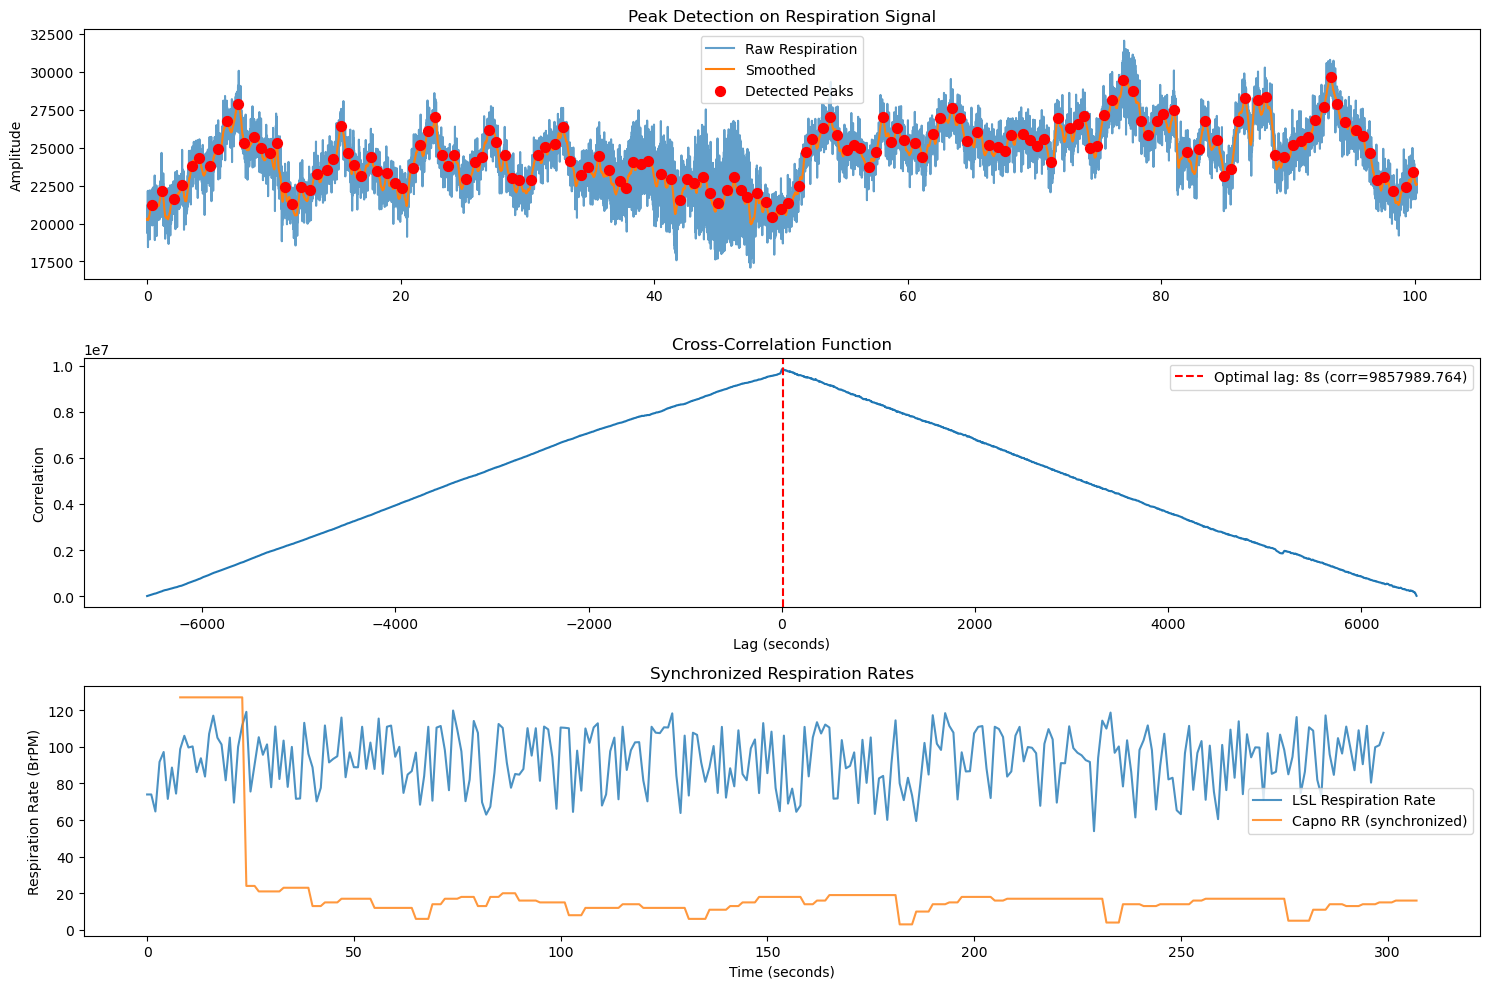

In [115]:
# ADD FNIRS AUXILIARIES

# Accelerometer
rec.aux_ts['ACCEL_X_1_native'] = rec.aux_ts.pop('ACCEL_X_1')
rec.aux_ts['ACCEL_Y_1_native'] = rec.aux_ts.pop('ACCEL_Y_1')
rec.aux_ts['ACCEL_Z_1_native'] = rec.aux_ts.pop('ACCEL_Z_1')
rec.aux_ts['GYRO_X_1_native'] = rec.aux_ts.pop('GYRO_X_1')
rec.aux_ts['GYRO_Y_1_native'] = rec.aux_ts.pop('GYRO_Y_1')
rec.aux_ts['GYRO_Z_1_native'] = rec.aux_ts.pop('GYRO_Z_1')

rec.aux_ts['acc_x'] = liveamp_aux_xr.sel(channel='ACC_X')
rec.aux_ts['acc_y'] = liveamp_aux_xr.sel(channel='ACC_Y')
rec.aux_ts['acc_z'] = liveamp_aux_xr.sel(channel='ACC_Z')


# Galvanic Skin Response
rec.aux_ts['gsr'] = liveamp_aux_xr.sel(channel='gsr')


# Respiration
rec.aux_ts['respiration'] = liveamp_aux_xr.sel(channel='respiration')


# Button press pandas dataframe
rec.aux_ts['button_press'] = transform_markers_data(button_press_data)


# Capnograph data
co2_synced, spo2_synced, hr_synced, rr_synced = sync_capnograph_to_lsl(
    rec, co2_xr, capnograph_trend_ds, show_plots=True
)

rec.aux_ts['CO2'] = co2_synced
rec.aux_ts['SpO2'] = spo2_synced
rec.aux_ts['heart_rate'] = hr_synced
rec.aux_ts['respiration_rate'] = rr_synced

In [116]:
# ADD FNIRS STIM

# PsychoPy markers
rec.stim = transform_markers_data(markers_data)


In [121]:
print(rec)

<Recording |  timeseries: ['amp_native', 'amp'],  masks: [],  stim: ['prep_bhb', 'bhb_interval', 'breath_hold', 'normal_breath', 'sitting_instr', 'pre_sitting', 'sitting_index_on', 'sitting_index_off', 'sitting_pinkie_on', 'sitting_pinkie_off', 'sitting_thumb_on', 'sitting_thumb_off', 'sitting_sham_on', 'sitting_sham_off', 'sitting_all_on', 'sitting_all_off', 'post_sitting', 'after_sitting', 'walking_instr', 'pre_walking', 'walking_thumb_on', 'walking_thumb_off', 'walking_all_on', 'walking_all_off', 'walking_index_on', 'walking_index_off', 'walking_pinkie_on', 'walking_pinkie_off', 'walking_sham_on', 'walking_sham_off', 'post_walking', 'after_walking', 'end_1'],  aux_ts: ['ACCEL_X_1_native', 'ACCEL_Y_1_native', 'ACCEL_Z_1_native', 'GYRO_X_1_native', 'GYRO_Y_1_native', 'GYRO_Z_1_native', 'acc_x', 'acc_y', 'acc_z', 'gsr', 'respiration', 'button_press', 'CO2', 'SpO2', 'heart_rate', 'respiration_rate'],  aux_obj: []>


In [120]:
print(aurora_acc_xr)

<xarray.DataArray (channel: 12, time: 434817)> Size: 21MB
array([[ 2.0000e+00,  2.0000e+00,  2.0000e+00, ...,  2.0000e+00,
         2.0000e+00,  2.0000e+00],
       [ 1.0000e+00,  1.0000e+00,  1.0000e+00, ...,  1.0000e+00,
         1.0000e+00,  1.0000e+00],
       [-2.2472e+00, -2.2496e+00, -2.2753e+00, ..., -2.1203e+00,
        -2.1376e+00, -2.1610e+00],
       ...,
       [ 7.5000e+00,  7.6875e+00,  7.6875e+00, ...,  7.8125e+00,
         7.8125e+00,  7.8125e+00],
       [-7.3125e+00, -7.8750e+00, -7.8750e+00, ...,  7.0625e+00,
         7.0625e+00,  7.0625e+00],
       [ 3.0000e+00,  1.0000e+00,  1.0000e+00, ...,  6.5444e+04,
         6.5444e+04,  6.5444e+04]], shape=(12, 434817), dtype=float32)
Coordinates:
  * time     (time) float64 3MB 1.666 1.676 1.686 ... 4.368e+03 4.368e+03
    samples  (time) int64 3MB 0 1 2 3 4 5 ... 434812 434813 434814 434815 434816
  * channel  (channel) <U16 768B 'device_id' ... 'hall_resistance'


In [105]:
print(rec.aux_ts['heart_rate'].time.values)

[   8.180000066757202    8.339999914169312    8.829999923706055 ...
 6619.77999997139     6620.02999997139     6620.2699999809265  ]


In [106]:
print(rec.aux_ts['gsr'])

<xarray.DataArray (time: 3208277)> Size: 13MB
array([-312166.1 , -312201.72, -312253.38, ..., -300453.9 , -300336.7 ,
       -300075.4 ], shape=(3208277,), dtype=float32)
Coordinates:
  * time     (time) float64 26MB 0.0 0.002003 0.004006 ... 6.572e+03 6.572e+03
    samples  (time) int64 26MB 0 1 2 3 4 ... 3208273 3208274 3208275 3208276
    channel  <U11 44B 'gsr'


AttributeError: 'RawArray' object has no attribute 'head'

In [127]:
mont = rec.geo3d

In [128]:
mont

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

<xarray.DataArray (label: 353, pos: 3)> Size: 8kB
<Quantity([[-78.8615 -11.3291  47.3124]
 [-55.9331 -10.1046  78.6421]
 [-85.3715 -16.08     8.9009]
 ...
 [ 77.521   28.883  -39.113 ]
 [ 80.59    14.229  -38.278 ]
 [ 81.95    -0.678  -37.027 ]], 'millimeter')>
Coordinates:
  * label    (label) <U6 8kB 'S1' 'S2' 'S3' 'S4' ... 'FFT10h' 'FT10h' 'FTT10h'
    type     (label) object 3kB PointType.SOURCE ... PointType.LANDMARK
Dimensions without coordinates: pos